#Empecemos con algo

In [1]:
import os
import pandas as pd 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


En el siguiente código para importar toda la información de una ciudad

In [2]:
base_dir=os.path.join('.','data')
output_dir=os.path.join('.','output')
ciudad='Valledupar'
fuente='IDEAM'

In [3]:
#Funcion que carga la serie de datos segun lo que se esta pidiendo
def cargarserie(base,city,source):
    serie_path=os.path.join(base,city,source+'.csv')
    serie_datos= pd.read_csv(serie_path,sep=';',encoding='latin-1')
    serie_datos= serie_datos.rename(index=str, columns={list(serie_datos)[-1]:'GHI'})
    return serie_datos

In [4]:
serie_pd=cargarserie(base_dir,ciudad,fuente)

In [5]:
def ghi_por_mes(serie_horaria):
    #Se obtienen las lista de los diferentes años
    agnos=sorted(serie_horaria['AÑO'].unique())
    meses=sorted(serie_horaria['MES'].unique())
    #Se crea un nuevo DATAFRAME donde se tendra la energia por mes
    ghi_df=pd.DataFrame(columns=['AÑO','MES','DIAS','GHImes','GHIdiario'])
     #AÑO
    for agno in agnos:
        for mes in meses:
           #OBTENER la ultima columna (energia)
            n_energia=list(serie_horaria)[-1]
            #Los dias del agno y mes actual (valores unicos)
            dias=serie_horaria[(serie_horaria['AÑO']==agno)&(serie_horaria['MES']==mes)]["DIA"].unique()
            #Energia por metro GHI*1hora [kWh]
            ghi_mes=serie_horaria.loc[(serie_horaria["AÑO"]==agno) & (serie_horaria['MES']==mes),n_energia].sum()/1000
            ghi_dia=ghi_mes/max(dias)
            #Se crea un diccionario de los datos recolectado para obtener el nuevo dataframe
            ghi_dict={"AÑO":agno, "MES":mes, "DIAS":max(dias),
                        "GHImes":ghi_mes,'GHIdiario':ghi_dia}
            #Se anexa el diccionario al final del dataframe que se esta creando
            ghi_df=ghi_df.append(ghi_dict,ignore_index=True)
    return ghi_df



In [6]:
ghi_mensual=ghi_por_mes(serie_pd)
datos_IDEAM=sorted(ghi_mensual["GHIdiario"])

a continuacion se grafican los Datos
      

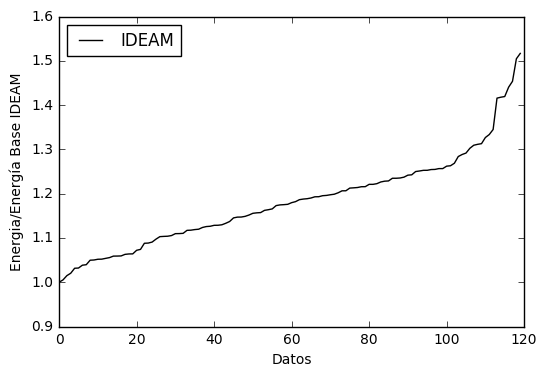

In [7]:
pylab.xlabel("Datos")
pylab.ylabel("Energia/Energía Base IDEAM")
numdatos=range(len(datos_IDEAM))
pylab.plot(numdatos,datos_IDEAM/ datos_IDEAM[0],'-k',label='IDEAM')
pylab.legend(loc='upper left')
pylab.show()
#Para guardar
#pylab.savefig(os.path.join(output_dir,'valledupar_IDEAM.png'), dpi=600)


In [8]:
percentil= 0.01
enficc = ghi_mensual["GHIdiario"].quantile(q=percentil)
print('La ENFICC 99% es:', enficc)

La ENFICC 99% es: 4.56900737661


Ahora se hara la funcion de la MCP usando Relacion de Varianzas

In [9]:
#Serie Corta
# Parametros son ango, mes inicio y # meses de serie

def serie_corta(serie_larga,ango,mes,duracion):
    #Se calcula el mes en el cual termina la cuenta
    mes_final=(((mes-1)+duracion)%12)+1
    #Se calcula el ango final
    ango_final=ango+(mes+duracion)//12
    #Si es el mismo agno
    if (ango-ango_final==0):
        serie_corta=serie_larga.loc[(serie_larga["AÑO"]>=ango)&(serie_larga["AÑO"]<=ango_final)
                    &(serie_larga["MES"]>=mes)&(serie_larga["MES"]<mes_final)]
    #Si solo es de un ango para el otro
    elif (ango_final-ango==1):
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]==ango_final)& (serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2])
    #Mas de un ango
    else:
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]>ango)&(serie_larga["AÑO"]<ango_final)]
        serie3=serie_larga.loc[(serie_larga["AÑO"]==ango_final)&(serie_larga["MES"]<=mes_final)]
        serie_corta=pd.concat([serie1,serie2,serie3])
    return serie_corta.copy()
  


In [10]:
#Obtener mismo periodo de 2 series (de la larga sacar las misma que la corta)
def mismo_periodo(serie_corta,serie_larga):
    ango_final=serie_corta["AÑO"].max()
    ango= serie_corta["AÑO"].min()
    mes=serie_corta.loc[serie_corta["AÑO"] == ango]['MES'].min()
    mes_final=serie_corta.loc[serie_corta["AÑO"] == ango_final]['MES'].max()
    
    #Si es el mismo agno
    if (ango==ango_final):
        serie_corta=serie_larga.loc[(serie_larga["AÑO"]==ango)
                    &(serie_larga["MES"]>=mes)&(serie_larga["MES"]<=mes_final)]
    #Si solo es de un ango para el otro
    elif (ango_final-ango==1):
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]==ango_final)& (serie_larga["MES"]<mes_final)]
        serie_corta=pd.concat([serie1,serie2])
    #Mas de un ango
    else:
        serie1=serie_larga.loc[(serie_larga["AÑO"]==ango)& (serie_larga["MES"]>=mes)]
        serie2=serie_larga.loc[(serie_larga["AÑO"]>ango)&(serie_larga["AÑO"]<ango_final)]
        serie3=serie_larga.loc[(serie_larga["AÑO"]==ango_final)&(serie_larga["MES"]<mes_final)]
        serie_corta=pd.concat([serie1,serie2,serie3])
    return serie_corta.copy()


In [11]:
def prediccion_VR(serie_obC,serie_refL):
    
    serie_refC=mismo_periodo(serie_obC,serie_refL)    
    
    ghi_obCH=serie_obC.iloc[:,-1]
    ghi_refCH=serie_refC.iloc[:,-1]
    ghi_refLH=serie_refL.iloc[:,-1]
    mu_obC=ghi_obCH.mean()
    mu_refC=ghi_refCH.mean()
    sigma_obC=ghi_obCH.std()
    sigma_refC=ghi_refCH.std()
    ghi_mes_obL=(mu_obC-(sigma_obC/sigma_refC)*mu_refC)+(
        sigma_obC/sigma_refC)*ghi_refLH
    # Correccion de noche
    ghi_mes_obL[(serie_refL["HORA"]<=5) | (serie_refL["HORA"]>=19)]= 0 
    
    return ghi_mes_obL
 

In [19]:
base_dir=os.path.join('.','data')
ciudad='Valledupar'
#  ESTO ESTA AL REVES
fObj='IDEAM'
fRef='NREL'

#Cargar cada serie segun la fuente
serie_ob=cargarserie(base_dir,ciudad,fObj)
serie_ref=cargarserie(base_dir,ciudad,fRef)

# de mes 3 2011 por 3 meses
#Solo se puede fechas entre 2006-2015
mes=6
agno=2008
dura=3


serie_obC=serie_corta(serie_ob,agno,mes,dura)
m=prediccion_VR(serie_obC,serie_ref)

ghi_pred=serie_ref.copy()
ghi_pred.loc[:,list(serie_ref)[-1]]=m

ghi_pred=mismo_periodo(serie_ob,ghi_pred)
ghi_pred



,AÑO,MES,DIA,HORA,GHI
8760,2006,1,1,0,0.000000
8761,2006,1,1,1,0.000000
8762,2006,1,1,2,0.000000
8763,2006,1,1,3,0.000000
8764,2006,1,1,4,0.000000
8765,2006,1,1,5,0.000000
8766,2006,1,1,6,8.853035
8767,2006,1,1,7,167.941377
8768,2006,1,1,8,387.225309
8769,2006,1,1,9,585.010816


 Funcion que remplaza el KSI : scipy.stats.ks_2samp obtener p-value